In [39]:
import pandas as pd
import sys
sys.path.append('..')
from utils import RewardModelWrapper, get_percent_chosen
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.special import softmax
import numpy as np
from calc_ece import get_metrics
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
df = pd.read_csv('../data/train_sets/openai_summarize_from_feedback/english_original.csv')
df

,prompt,chosen,rejected
0,My boyfriend and I are long distance. We have ...,I have made sure my mother is comfortable with...,Mum is mad at me for not flying on my own trip...
1,My boyfriend and I are long distance. We have ...,mum isn't speaking to me because I booked a fl...,I have made sure my mother is comfortable with...
2,My boyfriend and I are long distance. We have ...,mum isn't speaking to me because I booked a fl...,Mum thought I was going to road trip with my b...
3,My boyfriend and I are long distance. We have ...,Mum thought I was going to road trip with my b...,Mum is mad at me for not flying on my own trip...
4,My landlord left a falsified message taped to ...,landlord pretended to be another tenant and wr...,My landlord is harassing me and my neighbours ...
...,...,...,...
92857,"So.. TIFU about fifteen minutes ago, when I wa...","tried to get out of an assignment, ended up co...",Thought about trying to get out of work by bre...
92858,"So.. TIFU about fifteen minutes ago, when I wa...",TIFU by accidentily spilling half a glass of w...,TIFU by trying to get out of an assignment by ...
92859,"So.. TIFU about fifteen minutes ago, when I wa...","tried to get out of an assignment, ended up co...",TIFU by trying to get out of an assignment by ...
92860,"So.. TIFU about fifteen minutes ago, when I wa...",TIFU by accidentily spilling half a glass of w...,Thought about trying to get out of work by bre...


In [3]:
for c in df.columns:
    df = df[~df.duplicated(subset=c)].reset_index(drop=True)
df

,prompt,chosen,rejected
0,My boyfriend and I are long distance. We have ...,I have made sure my mother is comfortable with...,Mum is mad at me for not flying on my own trip...
1,My landlord left a falsified message taped to ...,landlord pretended to be another tenant and wr...,My landlord is harassing me and my neighbours ...
2,"A few months ago, I asked my RA if she wanted ...","RA owes me money, made me buy her toys in a fu...",RA verbally abused me and I want to get her to...
3,1) I got a DWI in 2014\n\n2) I have a wonderfu...,"10) On a scale from 1-10, how mad would you be...","I am stuck at work, my girlfriend is going to ..."
4,So my wedding dress arrived last week. I had s...,"My dress looks different to how I wanted it, h...",My mother asked my dress maker to change the d...
...,...,...,...
14739,"Hey, this is just a very minor thing. I'm a 16...","Ear pain, on decongestant, looking for somethi...",16 y/o. Swimmer. Had pain in ears. Decongestan...
14740,My girlfriend of six months goes to school in ...,Girlfriend has mental health issues and I want...,My depressed girlfriend is unhappy and I want ...
14741,My girlfriend and I have been dating for 2 yea...,I'm worried my girlfriend has borderline perso...,I believe my girlfriend exhibits symptoms of b...
14742,"About two years ago, I split with an ex who ow...",Ex filed multiple police reports against me. M...,I'd like to obtain all police reports on mysel...


In [4]:
to_calibrate = df.sample(1000, random_state=42).reset_index(drop=True)
to_calibrate

,prompt,chosen,rejected
0,"I have this good friend, we'll call him Steve....",I told him I like him but I don't want to date...,Sometimes my friend and I hug and hold hands. ...
1,"Met her online more than a year ago in a game,...",Crush is liking another guy and starts getting...,I planned to propose to my crush after her con...
2,Mine is that I once unknowingly lived on the s...,I lived on the same street as a girl with my e...,"Almost happened to me, then happened to me. Th..."
3,This is my girlfriend's mom's story. (Who from...,A group had hung a poster with a dick on it in...,How do you clean a room where all the furnitur...
4,"Hi, I'll try to keep this shortish and thanks ...",Is dating more than one person at a time ok? S...,I'm a single-female-dating-someone-at-a-time t...
...,...,...,...
995,All info has been altered as she's a redditor....,"met this amazing girl online, began talking al...","My dream girl told me she loves me, but is now..."
996,"My family is generally quite loud, especially ...","My family is generally loud, and I'm worried t...","My boyfriend is very shy, my family is very lo..."
997,Hi. I am about two months into my life at coll...,"I am falling for my roommate's boyfriend, and ...","I really like my roommate's boyfriend, and he ..."
998,I'm dating a girl who has a many interest and ...,Gf wants to do things I don't and I am not sur...,GF thinks I resent her for wanting more than me.


In [5]:
reward_model = RewardModelWrapper("OpenAssistant/reward-model-deberta-v3-large-v2")
to_calibrate_scores = reward_model.get_scores_df(to_calibrate)
to_calibrate_scores

100%|██████████| 1000/1000 [02:07<00:00,  7.82it/s]


,chosen,rejected
0,4.517087,-2.486554
1,6.375031,3.015603
2,5.557947,-4.884772
3,-3.392567,-5.751531
4,-4.312503,-5.855593
...,...,...
995,5.233577,1.946144
996,4.993377,6.718485
997,5.863507,3.715572
998,-5.580108,-4.807308


In [18]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)

def run_supervised_tempscaling(logits):
    """image_features, actual = get_image_features(model, dset, batch_size=128,
        device = device)
    actual = torch.IntTensor(actual).to(device).long()

    text = tokenizer([text_template.replace('{}',x) for x in dset.classes])
    with torch.no_grad(), torch.cuda.amp.autocast():
        text_features = model.encode_text(text.to(device))
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
    text_probs = (100.0 * image_features @ text_features.T)"""
    ## Setup LBGFS
    temperature = nn.Parameter((torch.ones(1)))
    args = {'temperature': temperature}
    criterion = nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')
    actual = torch.LongTensor([0] * len(logits))
    temps = []
    losses = []
    def _eval():
        loss = criterion(T_scaling(logits, args), actual)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        return loss
    optimizer.step(_eval)
    return temperature.item()


In [20]:
temp = run_supervised_tempscaling(torch.FloatTensor(to_calibrate_scores.values))
temp

0.8962845802307129

In [24]:
def calc_ece_acc(logits, temperature=1):
  scores = softmax(logits / temperature, axis=1)
  y_true = np.array([0] * len(scores)) # chosen is always class 0
  preds = scores.argmax(axis=1)
  confs = scores[np.arange(len(scores)), preds]
  ece, mce, acc = get_metrics(y_true=y_true, preds=preds, confs=confs)
  return ece, acc, confs

In [31]:
orig_scores = pd.read_csv('/home/ubuntu/code/neurips2023_distshift/model_scores/deberta_v3_large/open_ai_summarize_from_feedback/english_original_scores.csv')
calc_ece_acc(orig_scores.values, temperature=1)[0]

0.14528659532547955

Temperature grid search

In [86]:
temps = np.arange(0.01, 8, 0.05)
base_dir = '/home/ubuntu/code/neurips2023_distshift/model_scores/deberta_v3_large/open_ai_summarize_from_feedback/word_perturb/10k_subset/trial0'
ece_dict = {}
for inst in ['prompt', 'response', 'prompt_and_response']:
    subeces = {}
    subdir = f'{base_dir}/{inst}'
    for perturb_level in tqdm(os.listdir(subdir)):
        scores = pd.read_csv(f'{subdir}/{perturb_level}')
        perturb_level = int(perturb_level.split('_')[0]) / 10
        eces = [calc_ece_acc(scores.values, temperature=t)[0] for t in temps]
        subeces[perturb_level] = eces
    ece_dict[inst] = subeces

100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


In [87]:
def plot_ece_perturb(inst):
    for perturb_level in sorted(ece_dict[inst]):
        plt.plot(temps, ece_dict[inst][perturb_level], label=f'{perturb_level}', c = 'red', alpha=perturb_level + 0.1)
    plt.xlabel('Temperature')
    plt.ylabel('ECE')
    plt.suptitle('Temperature Grid Search for SummarizeFromFeedback')
    plt.title(inst)
    plt.ylim(0.0, 0.2)
    plt.legend()

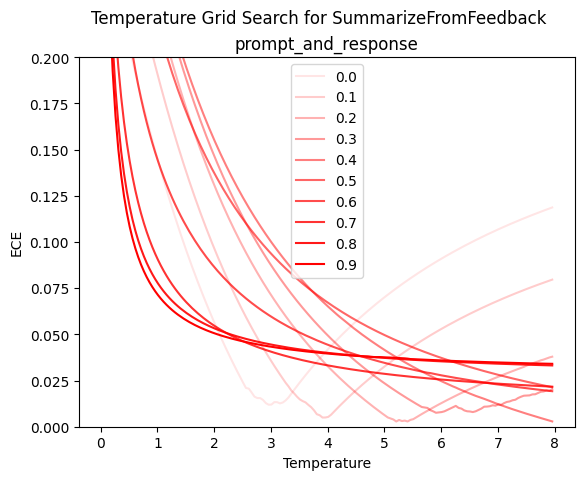

In [88]:
plot_ece_perturb('prompt_and_response')

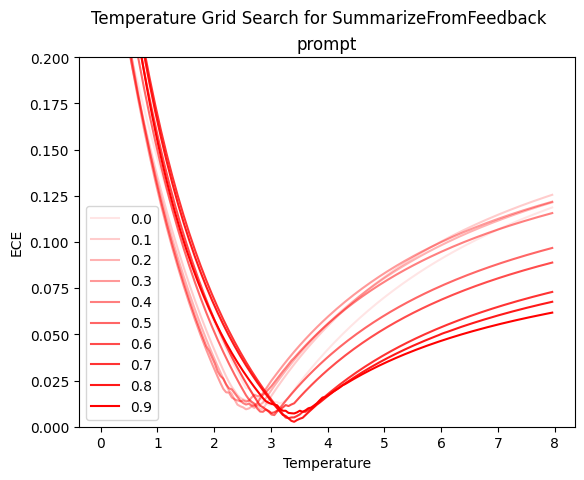

In [89]:
plot_ece_perturb('prompt')

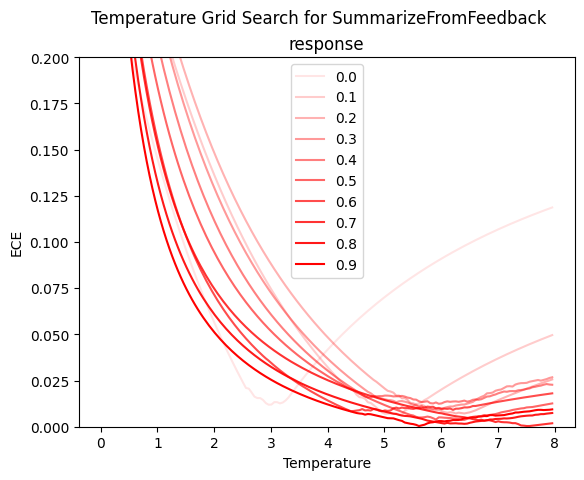

In [90]:
plot_ece_perturb('response')

In [32]:
calc_ece_acc(orig_scores.values, temperature=temp)[0]

0.15683901445084725

In [29]:
calc_ece_acc(to_calibrate_scores.values, temperature=1)[0]

0.018037577130895772

In [26]:
calc_ece_acc(to_calibrate_scores.values, temperature=temp)[0]

0.018371083620277298